# Fine-tuning BERT (base or large) on a Token-Classification (NER) task by using the library adapter-transformers (notebook version)

- **Credit**: [Hugging Face](https://huggingface.co/) and [adapter-transformers](https://github.com/Adapter-Hub/adapter-transformers)
- **Author**: [Pierre GUILLOU](https://www.linkedin.com/in/pierreguillou/)
- **Date**: 07/28/2021 (07/25/2021: version 1.2; 07/19/2021: version 1.1 and version 1.0)
- **Blog post**: [NLP nas empresas | Como ajustar um modelo de linguagem natural como BERT para a tarefa de classificação de tokens (NER) com um Adapter?](https://medium.com/@pierre_guillou/nlp-nas-empresas-como-ajustar-um-modelo-de-linguagem-natural-como-bert-para-a-tarefa-de-9c6a704bf536)
- **Link to the folder in github with this notebook and all necessary scripts**: [token-classification with adapters](https://github.com/piegu/language-models/tree/master/adapters/token-classification/)

## 1. Context

### Objective

The objective here is to **fine-tune a Masked Language Model (MLM) like BERT (base or large) for a Token-Classification (NER) task by training adapters (library [adapter-transformers](https://github.com/Adapter-Hub/adapter-transformers)), not the embeddings and transformers layers of the MLM model**, and to compare results with BERT model fully fine-tune for the same task.

The interest is obvious: if you need models for different NLP tasks, instead of fine-tuning and storing one model by NLP task, **you store only one MLM model and the trained tasks adapters which sizes are between 1% and 3% of the MLM model one** (it depends of the choosen adapter configuration). More, the loading of these adapters in production is very easy.

### Content

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model to a Token-Classification (NER) task, which is the task of predicting a label for each token. We will use the library [adapter-transformers](https://github.com/Adapter-Hub/adapter-transformers) and see how to easily load a dataset for these kinds of tasks and use the `Trainer` API to fine-tune a model on it.

![Widget inference representing the QA task](images/token_classification_adapter.png)

This notebook is built to run on any token classification task, with any model checkpoint from the [Model Hub](https://huggingface.co/models) as long as that model has a version with a token classification head and a fast tokenizer (check on [this table](https://huggingface.co/transformers/index.html#bigtable) if this is the case). It might just need some small adjustments if you decide to use a different dataset than the one used here. Depending on you model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those three parameters, then the rest of the notebook should run smoothly:

### History and Credit

This notebook is an adaptation of the following notebooks and scripts for **fine-tuning a (transformer) Masked Language Model (MLM) like BERT (base or large) on the Token-Classification (NER) task with any NER dataset** (we use here the [LeNER-br dataset](https://huggingface.co/datasets/lener_br):
- **from [adapter-transformers](https://github.com/Adapter-Hub/adapter-transformers)** | notebook [07a_Adapter_train_NER_with_id2label.ipynb](https://github.com/Adapter-Hub/adapter-transformers/blob/master/notebooks/07a_Adapter_train_NER_with_id2label.ipynb) and script [run_ner.py](https://github.com/Adapter-Hub/adapter-transformers/blob/master/examples/token-classification/run_ner.py) (this script was adapted from the script [run_qa.py](https://github.com/huggingface/transformers/blob/master/examples/pytorch/token-classification/run_ner.py) of HF)
- **from [transformers](https://github.com/huggingface/transformers) of Hugging Face** | notebook [token_classification.ipynb](https://github.com/huggingface/notebooks/blob/master/examples/token_classification.ipynb) and script [run_ner.py](https://github.com/huggingface/transformers/blob/master/examples/pytorch/token-classification/run_ner.py) 

In order to speed up the fine-tuning of the model on only one GPU, the library [DeepSpeed](https://www.deepspeed.ai/) could be used by applying the configuration provided by HF in the notebook [transformers + deepspeed CLI](https://github.com/stas00/porting/blob/master/transformers/deepspeed/DeepSpeed_on_colab_CLI.ipynb) but as the library adapter-transformers is not synchronized with the last version of the library transformers of HF, we keep that option for the future.

### Major changes from original notebooks and scripts

The notebook [token_classification.ipynb](https://github.com/huggingface/notebooks/blob/master/examples/token_classification.ipynb) and the script [run_ner.py](https://github.com/Adapter-Hub/adapter-transformers/blob/master/examples/token-classification/run_ner.py) allow to evaluate the model performance against f1 metric at the end of each epoch, and not against validation loss.

This is very important as we consider the metric when selecting a model, not the loss.

Therefore, we updated the notebook [token_classification.ipynb](https://github.com/huggingface/notebooks/blob/master/examples/token_classification.ipynb) to [token_classification_adapter.ipynb](https://github.com/piegu/language-models/blob/master/adapters/token_classification/token_classification_adapter.ipynb) with the following changes:
- **Weighted loss**: as the distribution of entities (tokens to find) is very unbalanced, you can choose to train the model with a weighted loss.
- **EarlyStopping** by selecting the model with the highest eval f1 (patience of 3 before ending the training)
- **MAD-X 2.0** that allows not to train adapters in the last transformer layer (read page 6 of [UNKs Everywhere: Adapting Multilingual Language Models to New Scripts](https://arxiv.org/pdf/2012.15562.pdf))
- **Stack method** for the lang and task adapters when a lang adapter is loaded ([doc](https://docs.adapterhub.ml/adapter_composition.html?highlight=stack#stack))
- **Houlsby MHA last layer** that allows no to train adapter after the Feed Fordward but only after the MHA (Multi-Head Attention) in the last layer for the Houlsby configuration

## 2. Installation

In [1]:
import pathlib
from pathlib import Path

#root path
root = Path.cwd()

In [2]:
import pickle
import pandas as pd

In [3]:
import sys; print('python:',sys.version)

import torch; print('Pytorch:',torch.__version__)

import transformers; print('adapter-transformers:',transformers.__version__)
import transformers; print('HF transformers:',transformers.__hf_version__)
import tokenizers; print('tokenizers:',tokenizers.__version__)
import datasets; print('datasets:',datasets.__version__)
from datasets import DatasetDict, Dataset, ClassLabel, Sequence

# import deepspeed; print('deepspeed:',deepspeed.__version__)

# Versions used in the virtuel environment of this notebook:

# python: 3.8.10 (default, Jun  4 2021, 15:09:15) 
# [GCC 7.5.0]
# Pytorch: 1.9.0
# adapter-transformers: 2.1.1
# transformers: 4.8.2
# tokenizers: 0.10.3
# datasets: 1.9.0

python: 3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]
Pytorch: 1.9.0
adapter-transformers: 2.1.1
HF transformers: 4.8.2
tokenizers: 0.10.3
datasets: 1.9.0


## 3. Model & dataset

In [4]:
# Select a MLM BERT base or large in the dataset language
# model_checkpoint = "neuralmind/bert-base-portuguese-cased"
model_checkpoint = "neuralmind/bert-large-portuguese-cased"
model_output = ""

# LeNER-br in Portuguese
dataset_name_hf = "lener_br" # name of the dataset in the Hugging Face dataset hub: https://huggingface.co/datasets
dataset_name = dataset_name_hf.replace('_','') # name of the dataset for this notebook

In [5]:
# train BERT with 2 sentences consecutive
next_sentence = True

## 4. Main hyperparameters

In [6]:
task = "ner"

In [7]:
# training arguments
batch_size = 8
gradient_accumulation_steps = 1

learning_rate = 1e-4
num_train_epochs = 20.
early_stopping_patience = 5

adam_epsilon = 1e-6

fp16 = True
ds = False # If True, we use DeepSpeed

# best model
load_best_model_at_end = True 
metric_for_best_model = "f1"
greater_is_better = True

# weighted loss
weighted_loss = False
if weighted_loss:
    c = 0.3
else:
    c = 0.0

In [8]:
# train adapter
train_adapter = True # we want to train an adapter
load_adapter = None # we do not upload an existing adapter 

# lang adapter
with_adapters_mlm = True # if False, we do not upload an existing lang adapter

if with_adapters_mlm:
    # define values to upload a specific lang adapter
    adapter_composition = "stack" # we will stack the lang and task adapters
else:
    adapter_composition = None

# if True, do not put adapter in the last transformer layer (Pfeiffer configuration)
madx2 = True

# if True, do not put adapter in the last transformer layer after the FeedFordarw block (Houlsby configuration)
houlsby_MHA_lastlayer = False

## 5. Configuration

### GPU

In [9]:
# gpu
n_gpu = 1 # train on just one GPU
gpu = 0 # select the GPU

In [10]:
# Select GPU 0
import os
os.environ['MASTER_ADDR'] = 'localhost'
if gpu == 0:
    os.environ['MASTER_PORT'] = '9999' # modify if RuntimeError: Address already in use # GPU 0
elif gpu == 1:
    os.environ['MASTER_PORT'] = '9997'
os.environ['RANK'] = "0"
os.environ['LOCAL_RANK'] = str(gpu)
os.environ['WORLD_SIZE'] = "1"

### Adapters config

#### Task adapter

In [11]:
# task adapter config
adapter_config_name = "pfeiffer" # houlsby is possible, too
if adapter_config_name == "pfeiffer":
    adapter_non_linearity = 'gelu' # relu is possible, too
elif adapter_config_name == "houlsby":
    adapter_non_linearity = 'swish'
adapter_reduction_factor = 16
language = 'pt' # pt = Portuguese

#### Lang adapter

In [12]:
if with_adapters_mlm:
    
    # hyperparameters used for fine-tuning the MLM with lang adapter
    learning_rate_mlm = 1e-4
    batch_size_mlm = 16
    gradient_accumulation_steps_mlm = 1
    adam_epsilon_mlm = 1e-6
    num_train_epoch_mlm = 100.
    early_stopping_patience_mlm = 10
    madx2_mlm = madx2
    houlsby_MHA_lastlayer_mlm = houlsby_MHA_lastlayer
    ds_mlm = False
    fp16_mlm = True
    load_best_model_at_end_mlm = True
    metric_for_best_model_mlm = "loss"
    adapter_config_mlm = adapter_config_name + '+inv'
    
    # path to lang adapter
    outputs_mlm = model_checkpoint.replace('/','-') + '_' + dataset_name + '/' + 'mlm' + '/' \
    + 'lr' + str(learning_rate_mlm) \
    + '_bs' + str(batch_size_mlm) \
    + '_GAS' + str(gradient_accumulation_steps_mlm) \
    + '_eps' + str(adam_epsilon_mlm) \
    + '_epochs' + str(num_train_epoch_mlm) \
    + '_patience' + str(early_stopping_patience_mlm) \
    + '_madx2' + str(madx2_mlm) \
    + '_houlsby_MHA_lastlayer' + str(houlsby_MHA_lastlayer_mlm) \
    + '_ds' + str(ds_mlm) \
    + '_fp16' + str(fp16_mlm) \
    + '_best' + str(load_best_model_at_end_mlm) \
    + '_metric' + str(metric_for_best_model_mlm) \
    + '_adapterconfig' + str(adapter_config_mlm)

    path_to_outputs_mlm = root/'outputs'/outputs_mlm
    
    # Config of the lang adapter
    lang_adapter_path = path_to_outputs_mlm/'adapters-mlm/'
    
    load_lang_adapter = str(lang_adapter_path)
    lang_adapter_config = str(lang_adapter_path) + "/adapter_config.json"
    if adapter_config_mlm == "pfeiffer+inv":
        lang_adapter_non_linearity = 'gelu' # relu is possible, too
    elif adapter_config_mlm == "houlsby+inv":
        lang_adapter_non_linearity = 'swish'
    lang_adapter_reduction_factor = 2
    language_mlm = language

### Training arguments of the HF trainer

In [13]:
# setup the training argument
do_train = True 
do_eval = True 

# if you want to test the trainer, set up the following variables
max_train_samples = 200 # None
max_val_samples = 50 # None

# epochs, bs, GA
evaluation_strategy = "epoch" 

# fp16
fp16_opt_level = 'O1'
fp16_backend = "auto"
fp16_full_eval = False

# optimizer (AdamW)
weight_decay = 0.01 # 0.0
adam_beta1 = 0.9
adam_beta2 = 0.999

# scheduler
lr_scheduler_type = 'linear'
warmup_ratio = 0.0
warmup_steps = 0

# logs
logging_strategy = "steps"
logging_first_step = True # False
logging_steps = 500     # if strategy = "steps"
eval_steps = logging_steps # logging_steps

# checkpoints
save_strategy = "epoch" # steps
save_steps = 500 # if save_strategy = "steps"
save_total_limit = 1 # None

# no cuda, seed
no_cuda = False
seed = 42

# bar
disable_tqdm = False # True
remove_unused_columns = True

In [14]:
# folder for training outputs

if model_checkpoint == "neuralmind/bert-large-portuguese-cased":
    outputs = model_checkpoint.replace('/','-') + '_' + dataset_name
else:
    outputs = model_output
    
if with_adapters_mlm:
    outputs = outputs + '/' + 'mlm_' + str(task) + '_AdCompo' + str(adapter_composition) + '/'
else:
    outputs = outputs + '/' + str(task) + '/'

outputs = outputs \
+ 'lr' + str(learning_rate) \
+ '_bs' + str(batch_size) \
+ '_GAS' + str(gradient_accumulation_steps) \
+ '_eps' + str(adam_epsilon) \
+ '_epochs' + str(num_train_epochs) \
+ '_patience' + str(early_stopping_patience) \
+ '_wamlm' + str(with_adapters_mlm) \
+ '_madx2' + str(madx2) \
+ '_houlsby_MHA_lastlayer' + str(houlsby_MHA_lastlayer) \
+ '_ds' + str(ds) \
+ '_fp16' + str(fp16) \
+ '_best' + str(load_best_model_at_end) \
+ '_metric' + str(metric_for_best_model) \
+ '_weightedloss' + str(weighted_loss) \
+ '_c' + str(c) \
+ '_ns' + str(next_sentence) \
+ '_adapterconfig' + str(adapter_config_name)

# path to outputs
path_to_outputs = root/'outputs'/outputs

# subfolder for model outputs
output_dir = path_to_outputs/'output_dir' 
overwrite_output_dir = True # False

# logs
logging_dir = path_to_outputs/'logging_dir'

## 6. Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [15]:
from datasets import load_dataset, load_metric

For our example here, we'll use the [lener_br dataset](https://huggingface.co/datasets/lener_br). The notebook should work with any token classification dataset provided by the 🤗 Datasets library. If you're using your own dataset defined from a JSON or csv file (see the [Datasets documentation](https://huggingface.co/docs/datasets/loading_datasets.html#from-local-files) on how to load them), it might need some adjustments in the names of the columns used.

In [ ]:
datasets = load_dataset(dataset_name_hf)

The `datasets` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set.

In [17]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'ner_tags', 'tokens'],
        num_rows: 7828
    })
    validation: Dataset({
        features: ['id', 'ner_tags', 'tokens'],
        num_rows: 1177
    })
    test: Dataset({
        features: ['id', 'ner_tags', 'tokens'],
        num_rows: 1390
    })
})

We can see the training, validation and test sets all have a column for the tokens (the input texts split into words) and one column of labels for each kind of task we introduced before.

To access an actual element, you need to select a split first, then give an index:

In [18]:
datasets["train"][0]

{'id': '0',
 'ner_tags': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'tokens': ['EMENTA',
  ':',
  'APELAÇÃO',
  'CÍVEL',
  '-',
  'AÇÃO',
  'DE',
  'INDENIZAÇÃO',
  'POR',
  'DANOS',
  'MORAIS',
  '-',
  'PRELIMINAR',
  '-',
  'ARGUIDA',
  'PELO',
  'MINISTÉRIO',
  'PÚBLICO',
  'EM',
  'GRAU',
  'RECURSAL',
  '-',
  'NULIDADE',
  '-',
  'AUSÊNCIA',
  'DE',
  'INTERVENÇÃO',
  'DO',
  'PARQUET',
  'NA',
  'INSTÂNCIA',
  'A',
  'QUO',
  '-',
  'PRESENÇA',
  'DE',
  'INCAPAZ',
  '-',
  'PREJUÍZO',
  'EXISTENTE',
  '-',
  'PRELIMINAR',
  'ACOLHIDA',
  '-',
  'NULIDADE',
  'RECONHECIDA',
  '.']}

The labels are already coded as integer ids to be easily usable by our model, but the correspondence with the actual categories is stored in the `features` of the dataset:

In [19]:
datasets["train"].features[f"ner_tags"]

Sequence(feature=ClassLabel(num_classes=13, names=['O', 'B-ORGANIZACAO', 'I-ORGANIZACAO', 'B-PESSOA', 'I-PESSOA', 'B-TEMPO', 'I-TEMPO', 'B-LOCAL', 'I-LOCAL', 'B-LEGISLACAO', 'I-LEGISLACAO', 'B-JURISPRUDENCIA', 'I-JURISPRUDENCIA'], names_file=None, id=None), length=-1, id=None)

So for the NER tags, 0 corresponds to 'O', 1 to 'B-ORGANIZACAO' etc... On top of the 'O' (which means no special entity), there are four labels for NER here, each prefixed with 'B-' (for beginning) or 'I-' (for intermediate), that indicate if the token is the first one for the current group with the label or not:
- 'ORGANIZACAO' for organization
- 'PESSOA' for person
- 'TEMPO' for data
- 'LOCAL' for location
- 'LEGISLACAO' for legislation
- 'JURISPRUDENCIA' for jurisprudence

Since the labels are lists of `ClassLabel`, the actual names of the labels are nested in the `feature` attribute of the object above:

In [20]:
label_list = datasets["train"].features[f"{task}_tags"].feature.names
label_list

['O',
 'B-ORGANIZACAO',
 'I-ORGANIZACAO',
 'B-PESSOA',
 'I-PESSOA',
 'B-TEMPO',
 'I-TEMPO',
 'B-LOCAL',
 'I-LOCAL',
 'B-LEGISLACAO',
 'I-LEGISLACAO',
 'B-JURISPRUDENCIA',
 'I-JURISPRUDENCIA']

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset (automatically decoding the labels in passing).

In [21]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [22]:
show_random_elements(datasets["train"])

,id,ner_tags,tokens
0,4329,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-LOCAL, I-LOCAL, I-LOCAL, B-ORGANIZACAO, I-ORGANIZACAO, I-ORGANIZACAO, O, O, O, B-LOCAL, I-LOCAL, I-LOCAL, I-LOCAL, O, O, O, B-LOCAL, I-LOCAL, O, O, O, O, O, O, O, O, B-LOCAL, I-LOCAL, O, O, O, O, O, B-JURISPRUDENCIA, I-JURISPRUDENCIA, I-JURISPRUDENCIA, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...]","[Por, outro, lado, ,, a, adoção, do, entendimento, de, que, basta, a, publicação, do, Acórdão, embargado, para, que, o, banco, se, dê, por, intimado, para, o, cumprimento, do, contido, na, sentença, exequenda, nos, autos, em, que, se, prolatou, a, decisão, recorrida, PODER, JUDICIÁRIO, DO, ESTADO, DO, ACRE, Segunda, Câmara, Cível, 10, Endereço, :, Rua, Tribunal, de, Justiça, ,, s/n, ,, Via, Verde, ,, CEP, 69.915-631, ,, Tel., 68, 3302-0444/0445, ,, Rio, Branco-AC, -, Mod, ., 500258, -, Autos, n.º, 1002199-81.2017.8.01.0000/50000, se, deu, por, razões, igualmente, claras, ,, verbis, :, Por, outro, lado, ,, é, inequívoco, ,, pelo, transcurso, do, tempo, ...]"
1,6546,"[O, B-ORGANIZACAO, O, O, B-ORGANIZACAO, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[A, Anvisa, e, a, União, são, partes, legítimas, para, responder, a, ação, que, busca, aplicar, às, propagandas, comerciais, o, conceito, de, bebida, alcoólica, mais, restritivo, .]"
2,5840,"[O, O, O, O]","[PRISÃO, EX, LEGE, .]"
3,690,"[B-PESSOA, I-PESSOA, I-PESSOA, I-PESSOA, O, O, O, O, O, O, O, B-ORGANIZACAO, I-ORGANIZACAO, I-ORGANIZACAO, I-ORGANIZACAO, I-ORGANIZACAO, I-ORGANIZACAO, O, O]","[Jorge, Ulisses, Jacoby, Fernandes, (, 6.546/OAB-DF, ), e, outros, ,, representando, Grupo, Ok, Construções, e, Empreendimentos, Ltda., 8.2, .]"
4,7728,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[O, atual, critério, a, ser, adotado, é, da, incidência, ou, não, da, multa, ,, examinada, em, cada, caso, concreto, .]"
5,4842,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-LEGISLACAO, I-LEGISLACAO, I-LEGISLACAO, I-LEGISLACAO, I-LEGISLACAO, I-LEGISLACAO, O, O, O, O, O, O, O, O, O, O, B-LEGISLACAO, I-LEGISLACAO, I-LEGISLACAO, I-LEGISLACAO, I-LEGISLACAO, I-LEGISLACAO, I-LEGISLACAO, I-LEGISLACAO, O]","[A, competência, da, Justiça, do, Trabalho, abrange, a, execução, de, ofício, das, contribuições, previdenciárias, previstas, no, artigo, 195, ,, da, Constituição, Federal, ,, decorrentes, das, decisões, que, proferir, ,, nos, termos, do, artigo, 114, ,, VIII, ,, da, Carta, Magna, .]"
6,1876,"[B-PESSOA, O, O, O, O, O, O, O, O, O, O]","[RUTH, ,, com, o, claro, intuito, de, desqualificá-la, como, candidata, .]"
7,6918,"[O, O, O, O]","[NULIDADE, DO, PROCESSO, .]"
8,5005,"[O, O]","[12, .]"
9,4723,"[O, O, O, O]","[COMPLEMENTAÇÃO, DE, APOSENTADORIA, .]"


### Dataset analysis

In [23]:
import matplotlib.pyplot as plt

In [24]:
labels = datasets["train"].features[f"ner_tags"].feature.names
labels

['O',
 'B-ORGANIZACAO',
 'I-ORGANIZACAO',
 'B-PESSOA',
 'I-PESSOA',
 'B-TEMPO',
 'I-TEMPO',
 'B-LOCAL',
 'I-LOCAL',
 'B-LEGISLACAO',
 'I-LEGISLACAO',
 'B-JURISPRUDENCIA',
 'I-JURISPRUDENCIA']

<ipython-input-25-86be45362280>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  col.set_xticklabels(labels=list(sorted_ner_tags_dist.keys()),rotation=45)
<ipython-input-25-86be45362280>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  col.set_xticklabels(labels=list(sorted_ner_tags_dist_without_O.keys()),rotation=45)


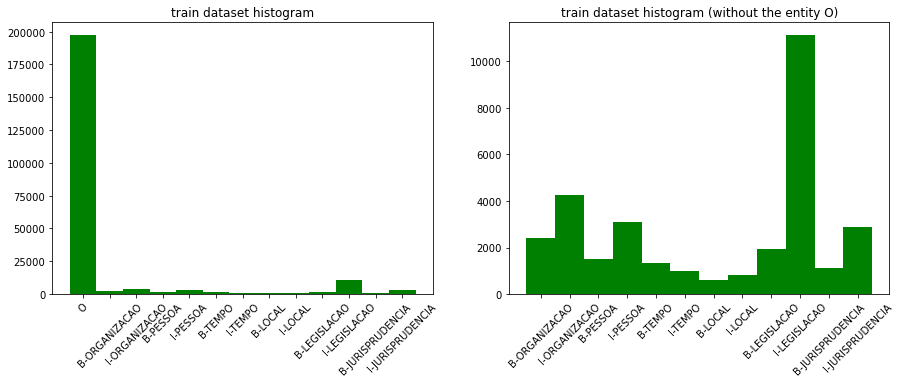

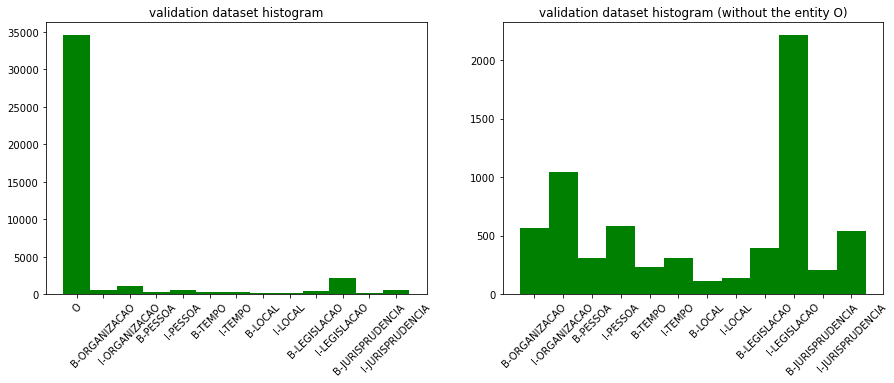

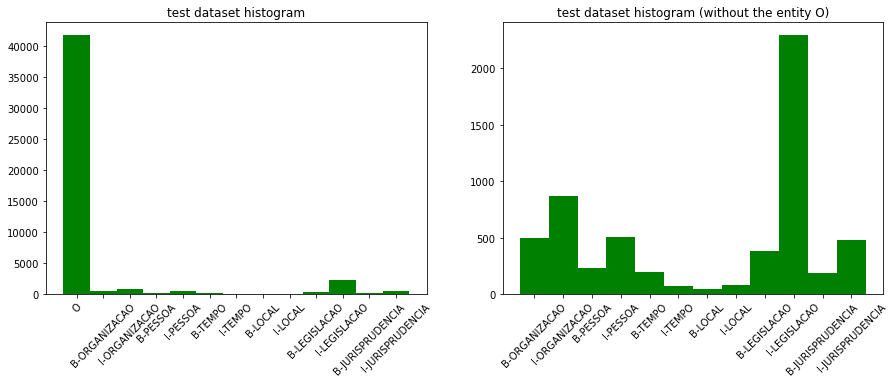

In [25]:
dsets = ["train","validation","test"]
for dset in dsets:
    # all tags
    ner_tags_list = list()
    for i,row in enumerate(datasets[dset]):
        ner_tags_list += row['ner_tags']

    # unique ner tags
    ner_tags_unique = list(set(ner_tags_list))
    ner_tags_unique = [labels[i] for i in ner_tags_unique]

    # Analyse the Tag distribution
    from collections import Counter
    ner_tags_dist = Counter(ner_tags_list)
    ner_tags_dist = {labels[k]:v for k,v in ner_tags_dist.items()}
    sorted_ner_tags_dist = {k:ner_tags_dist[k] for k in labels}
    
    fig = plt.figure(figsize=(15,5))
    axes = fig.subplots(nrows=1, ncols=2)

    for i,col in enumerate(axes):
            if i == 0: 
                col.bar(sorted_ner_tags_dist.keys(), sorted_ner_tags_dist.values(), width=1, color='g')
                col.set_xticklabels(labels=list(sorted_ner_tags_dist.keys()),rotation=45)
                col.set_title(f'{dset} dataset histogram')
            if i == 1:
                sorted_ner_tags_dist_without_O = sorted_ner_tags_dist.copy()
                del_value = sorted_ner_tags_dist_without_O.pop('O')
                col.bar(sorted_ner_tags_dist_without_O.keys(), sorted_ner_tags_dist_without_O.values(), width=1, color='g')
                col.set_xticklabels(labels=list(sorted_ner_tags_dist_without_O.keys()),rotation=45)
                col.set_title(f'{dset} dataset histogram (without the entity O)')

    plt.show()

There are 2 facts: the labels categories are very imbalanced and the train, validation and test datasets distributions are similar (which is a positive point).

As a solution to the first point, we could test a weighted loss function in the `trainer`. 

## 7. Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [26]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

The following assertion ensures that our tokenizer is a fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, and we will need some of the special features they have for our preprocessing.

In [27]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

You can check which type of models have a fast tokenizer available and which don't on the [big table of models](https://huggingface.co/transformers/index.html#bigtable).

You can directly call this tokenizer on one sentence:

In [28]:
tokenizer("O termo de compromisso deverá ser firmado pelo estagiário.")

{'input_ids': [101, 231, 2476, 125, 11798, 11588, 333, 16315, 243, 423, 418, 2245, 488, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

If, as is the case here, your inputs have already been split into words, you should pass the list of words to your tokenzier with the argument `is_split_into_words=True`:

In [29]:
tokenizer(["O", "termo", "de", "compromisso", "deverá", "ser", "firmado", "pelo", "estagiário", "."], is_split_into_words=True)

{'input_ids': [101, 231, 2476, 125, 11798, 11588, 333, 16315, 243, 423, 418, 2245, 488, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Note that transformers are often pretrained with subword tokenizers, meaning that even if your inputs have been split into words already, each of those words could be split again by the tokenizer. Let's look at an example of that:

In [30]:
example = datasets["train"][4]
print(example["tokens"])

['-', 'Preliminar', 'acolhida', 'para', 'reconhecer', 'a', 'nulidade', 'da', 'sentença', '.']


In [31]:
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)

['[CLS]', '-', 'Pre', '##lim', '##inar', 'acolh', '##ida', 'para', 'reconhecer', 'a', 'nu', '##li', '##dade', 'da', 'sentença', '.', '[SEP]']


Here the words "Zwingmann" and "sheepmeat" have been split in three subtokens.

This means that we need to do some processing on our labels as the input ids returned by the tokenizer are longer than the lists of labels our dataset contain, first because some special tokens might be added (we can a `[CLS]` and a `[SEP]` above) and then because of those possible splits of words in multiple tokens:

In [32]:
len(example[f"{task}_tags"]), len(tokenized_input["input_ids"])

(10, 17)

Thankfully, the tokenizer returns outputs that have a `word_ids` method which can help us.

In [33]:
print(tokenized_input.word_ids())

[None, 0, 1, 1, 1, 2, 2, 3, 4, 5, 6, 6, 6, 7, 8, 9, None]


As we can see, it returns a list with the same number of elements as our processed input ids, mapping special tokens to `None` and all other tokens to their respective word. This way, we can align the labels with the processed input ids.

In [34]:
word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else example[f"{task}_tags"][i] for i in word_ids]
print(len(aligned_labels), len(tokenized_input["input_ids"]))

17 17


Here we set the labels of all special tokens to -100 (the index that is ignored by PyTorch) and the labels of all other tokens to the label of the word they come from. Another strategy is to set the label only on the first token obtained from a given word, and give a label of -100 to the other subtokens from the same word. We propose the two strategies here, just change the value of the following flag:

In [35]:
label_all_tokens = True

We're now ready to write the function that will preprocess our samples. We feed them to the `tokenizer` with the argument `truncation=True` (to truncate texts that are bigger than the maximum size allowed by the model) and `is_split_into_words=True` (as seen above). Then we align the labels with the token ids using the strategy we picked:

In [36]:
# original function: 1 sentence for the validation and test dataset
def tokenize_and_align_labels(examples):
#     tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True, max_length=512)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [37]:
# new with 2 sentences for the training dataset
def tokenize_and_align_labels_next(examples):
#     tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    tokens_sentence = examples["tokens_sentence"]
    tokens_second_sentence = examples["tokens_second_sentence"]
    tokenized_inputs = tokenizer(tokens_sentence, tokens_second_sentence, truncation=True, is_split_into_words=True, max_length=512)

    labels = []
    
    ner_tags_sentence = examples["ner_tags_sentence"]
    ner_tags_second_sentence = examples["ner_tags_second_sentence"]
    ner_tags_list = [tags1+tags2 for tags1, tags2 in zip(ner_tags_sentence, ner_tags_second_sentence)]
    
    for i, label in enumerate(ner_tags_list):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key.

As you need to pass 2 consecutives sentences, let's create the `datasets` object `new_datasets` that contains the 3 datasets train, validation, test with a shifted of one sentence for train. Validation and test stay with just one sentence.

In [38]:
%%time
if next_sentence:
    
    # train dataset
    folders = ['train']
    new_datasets = DatasetDict()

    for folder in folders:    

        # content creation
        new_ids = list()
        tokens_sentence = list()
        tokens_second_sentence = list()
        ner_tags_sentence = list()
        ner_tags_second_sentence = list()

        df = datasets[folder].to_pandas()

        for index, row in df.iterrows():
            new_ids.append(index)
            if index < len(df) - 1:
                tokens_sentence.append(row['tokens'].tolist())
                tokens_second_sentence.append(df['tokens'][index+1].tolist())
                ner_tags_sentence.append(row['ner_tags'].tolist())
                ner_tags_second_sentence.append(df['ner_tags'][index+1].tolist())
            else:
                tokens_sentence.append(row['tokens'].tolist())
                tokens_second_sentence.append(df['tokens'][0].tolist())
                ner_tags_sentence.append(row['ner_tags'].tolist())
                ner_tags_second_sentence.append(df['ner_tags'][0].tolist())

        # new DataFrame
        columns = ['id','tokens_sentence','tokens_second_sentence','ner_tags_sentence','ner_tags_second_sentence']
        df_new = pd.DataFrame(columns=columns)
        df_new['id'] = pd.Series(new_ids)
        df_new['tokens_sentence'] = pd.Series(tokens_sentence)
        df_new['tokens_second_sentence'] = pd.Series(tokens_second_sentence)
        df_new['ner_tags_sentence'] = pd.Series(ner_tags_sentence)
        df_new['ner_tags_second_sentence'] = pd.Series(ner_tags_second_sentence)

        # new Dataset   
        new_datasets[folder] = Dataset.from_pandas(df_new)

        # setup features
        from datasets import Value 
        new_datasets[folder].features['tokens_sentence'] = datasets[folder].features['tokens']
        new_datasets[folder].features['tokens_second_sentence'] = datasets[folder].features['tokens']
        new_datasets[folder].features['ner_tags_sentence'] = datasets[folder].features['ner_tags']
        new_datasets[folder].features['ner_tags_second_sentence'] = datasets[folder].features['ner_tags']
        
    # validation and test datasets
    folders = ['validation', 'test']

    for folder in folders:
        if len(datasets[folder][0]['tokens']) > 0:
            new_datasets[folder] = datasets[folder]
        else:
            # we do not keep the first row as it has no content
            new_datasets[folder] = datasets[folder].select(list(range(1,datasets[folder].num_rows)))

CPU times: user 978 ms, sys: 25.9 ms, total: 1 s
Wall time: 1.1 s


In [39]:
if next_sentence:
    print(new_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens_sentence', 'tokens_second_sentence', 'ner_tags_sentence', 'ner_tags_second_sentence'],
        num_rows: 7828
    })
    validation: Dataset({
        features: ['id', 'ner_tags', 'tokens'],
        num_rows: 1177
    })
    test: Dataset({
        features: ['id', 'ner_tags', 'tokens'],
        num_rows: 1390
    })
})


In [40]:
if next_sentence:
    print(tokenize_and_align_labels_next(new_datasets['train'][:2]))
else:
    print(tokenize_and_align_labels(datasets['train'][:2]))

{'input_ids': [[101, 192, 7463, 8427, 22301, 131, 12127, 9008, 22301, 22402, 16484, 187, 22360, 22339, 9008, 118, 177, 22402, 16484, 10836, 13760, 7545, 22320, 22323, 22351, 22301, 22402, 16484, 212, 8718, 250, 7665, 6072, 213, 8718, 22301, 6538, 118, 11635, 9008, 13270, 7073, 6765, 118, 11741, 22328, 22341, 6392, 22301, 212, 9008, 22317, 213, 7073, 6538, 22321, 22352, 21748, 22317, 212, 22371, 22318, 22327, 6162, 22317, 192, 22311, 278, 5650, 22341, 257, 5476, 15289, 5903, 22327, 118, 248, 18199, 6392, 11836, 22309, 118, 177, 10409, 22420, 22320, 14298, 22301, 10836, 13760, 16017, 22322, 22339, 12547, 22402, 16484, 15040, 18868, 22322, 22349, 22341, 9208, 248, 22301, 13760, 11846, 22379, 22320, 14298, 22301, 177, 5226, 22341, 22317, 118, 11635, 3341, 12547, 22402, 22301, 10836, 13760, 4529, 5869, 22351, 118, 11635, 22309, 22333, 22341, 22360, 22351, 22317, 192, 22348, 6538, 16017, 8427, 22309, 118, 11635, 9008, 13270, 7073, 6765, 11247, 7918, 22340, 6392, 22301, 118, 248, 18199, 6392,

In [41]:
if next_sentence:
    tokenized_datasets = DatasetDict()
    folders = ['train', 'validation', 'test']

    for folder in folders:
        if folder == 'train':
            tokenized_datasets[folder] = new_datasets[folder].map(tokenize_and_align_labels_next, batched=True,
                                                                   remove_columns=new_datasets[folder].column_names)
        else:
            tokenized_datasets[folder] = new_datasets[folder].map(tokenize_and_align_labels, batched=True,
                                                                  remove_columns=new_datasets[folder].column_names) 
else:
    tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

In [42]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 7828
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 1177
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 1390
    })
})

Let's verify that the training dataset has 2 tokonized sentences (`token_type_ids` = 0 and 1) and validation/test only one (`token_type_ids` = 0).

In [43]:
folders = ['train', 'validation', 'test']

for folder in folders:
    print(folder, tokenized_datasets[folder][0]['token_type_ids'][:40])

train [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
validation [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
test [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Let's check the min and max of tokens in our tokenized sentences.

In [44]:
folders = ["train", "validation", "test"]
tokens_length = dict()

for folder in folders:
    tokens_length[folder] = list()
    for i in range(tokenized_datasets[folder].num_rows):
        tokens_length[folder].append(len(tokenized_datasets[folder][i]['token_type_ids']))
    print(f'{folder} min tokens: {min(tokens_length[folder])} - max tokens: {max(tokens_length[folder])}')

train min tokens: 7 - max tokens: 512
validation min tokens: 2 - max tokens: 505
test min tokens: 2 - max tokens: 512


Let's display the histograms of our tokenized train, validation and test set.

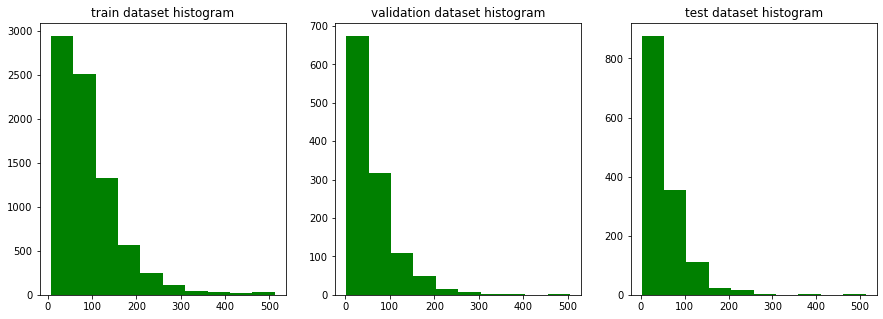

In [45]:
fig = plt.figure(figsize=(15,5))
axes = fig.subplots(nrows=1, ncols=3)

for i,col in enumerate(axes):
    folder = folders[i]
    col.hist(tokens_length[folder], color='g')
    col.set_title(f'{folder} dataset histogram')

plt.show()

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## 8. Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since all our tasks are about token classification, we use the `AutoModelForTokenClassification` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us. The only thing we have to specify is the number of labels for our problem (which we can get from the features, as seen before):

In [46]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

Some weights of the model checkpoint at /mnt/home/pierre/course-v4/nbs/MLM/neuralmind-bert-large-portuguese-cased-lenerbr/mlm_base were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initial

The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

In [47]:
# number of model parameters
model_num_param=0
for p in model.parameters():
    model_num_param+=p.numel()
model_num_param

333360141

## 9. Adapters

In [48]:
# Setup adapters
from transformers.adapters.composition import Stack
from transformers import AdapterConfig

if train_adapter:
        
    # new
    if madx2:
        # do not add adapter in the last transformer layers 
        leave_out = [len(model.bert.encoder.layer)-1]
    else:
        leave_out = []
        
    # new
    # task_name = data_args.dataset_name or "mlm"
    task_name = "ner"
    
    # optionally load another pre-trained language adapter
    if with_adapters_mlm:
        # resolve the language adapter config
        lang_adapter_config = AdapterConfig.load(
                lang_adapter_config,
                non_linearity=lang_adapter_non_linearity,
                reduction_factor=lang_adapter_reduction_factor,
                leave_out=leave_out,
            )
        # load the language adapter from Hub
        task_mlm_load_as = 'mlm'
        lang_adapter_name = model.load_adapter(
                load_lang_adapter,
                config=lang_adapter_config,
                load_as=task_mlm_load_as,
                with_head = False
            )
    else:
        lang_adapter_name = None
        
    # check if adapter already exists, otherwise add it
    if task_name not in model.config.adapters:
            
#             # resolve the adapter config
#             adapter_config = AdapterConfig.load(
#                 adapter_args.adapter_config,
#                 non_linearity=adapter_args.adapter_non_linearity,
#                 reduction_factor=adapter_args.adapter_reduction_factor,
#             )

        # new
        # resolve adapter config with (eventually) the MAD-X 2.0 option
        if adapter_config_name == "pfeiffer":
            from transformers.adapters.configuration import PfeifferConfig
            adapter_config = PfeifferConfig(non_linearity=adapter_non_linearity,
                                            reduction_factor=adapter_reduction_factor,
                                            leave_out=leave_out)           
        elif adapter_config_name == "pfeiffer+inv":
            from transformers.adapters.configuration import PfeifferInvConfig
            adapter_config = PfeifferInvConfig(non_linearity=adapter_non_linearity,
                                               reduction_factor=adapter_reduction_factor,
                                               leave_out=leave_out)          
        elif adapter_config_name == "houlsby":
            from transformers.adapters.configuration import HoulsbyConfig
            adapter_config = HoulsbyConfig(non_linearity=adapter_non_linearity,
                                           reduction_factor=adapter_reduction_factor,
                                           leave_out=leave_out)
        elif adapter_config_name == "houlsby+inv":
            from transformers.adapters.configuration import HoulsbyInvConfig
            adapter_config = HoulsbyInvConfig(non_linearity=adapter_non_linearity,
                                              reduction_factor=adapter_reduction_factor,
                                              leave_out=leave_out)              
                
        # load a pre-trained from Hub if specified
        if load_adapter:
            model.load_adapter(
                    load_adapter,
                    config=adapter_config,
                    load_as=task_name,
                    with_head = False
                )
        # otherwise, add a fresh adapter
        else:
            model.add_adapter(task_name, config=adapter_config)
            
    # Set the adapters to be used in every forward pass
    if lang_adapter_name:
        model.active_adapters = Stack(task_mlm_load_as, task_name)
    else:
        model.set_active_adapters(task_name)

    # Freeze all model weights except of those of this adapter
    model.train_adapter([task_name])
    
else:
    if load_adapter or load_lang_adapter:
        raise ValueError(
                "Adapters can only be loaded in adapters training mode."
                "Use --train_adapter to enable adapter training"
            )

In [49]:
# Put only the adapter after the MHA but not after the FeedForward in the last layer
if houlsby_MHA_lastlayer \
and train_adapter \
and not madx2 \
and task_name in model.config.adapters \
and (adapter_config_name == "houlsby" or adapter_config_name == "houlsby+inv"):
    import torch
    from torch.nn import ModuleDict
    model.bert.encoder.layer[len(model.bert.encoder.layer)-1].output.adapters = ModuleDict()

In [50]:
model_adapter_num_param=0
for p in model.parameters():
    model_adapter_num_param+=p.numel()
model_adapter_num_param

361078221

In [51]:
print(f"Number of parameters of the model with adapter: {model_adapter_num_param:.0f}")
print(f"Number of parameters of the model without adapter: {model_num_param:.0f}")
print(f"Number of parameters of the adapter: {model_adapter_num_param - model_num_param:.0f}")
print(f"Pourcentage of additional parameters through adapter:",round(((model_adapter_num_param - model_num_param)/model_num_param)*100,2),'%')

Number of parameters of the model with adapter: 361078221
Number of parameters of the model without adapter: 333360141
Number of parameters of the adapter: 27718080
Pourcentage of additional parameters through adapter: 8.31 %


## 10. Training

To instantiate a `Trainer`, we will need to define three more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [52]:
from transformers import TrainingArguments

if ds:
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=overwrite_output_dir,
        do_train=do_train,
        do_eval=do_eval,
        evaluation_strategy=evaluation_strategy,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        adam_beta1=adam_beta1,
        adam_beta2=adam_beta2,
        adam_epsilon=adam_epsilon,
        num_train_epochs=num_train_epochs,
        lr_scheduler_type=lr_scheduler_type,
        warmup_ratio=warmup_ratio,
        warmup_steps=warmup_steps,
        logging_dir=logging_dir,         # directory for storing logs
        logging_strategy=evaluation_strategy,
        logging_steps=logging_steps,     # if strategy = "steps"
        save_strategy=evaluation_strategy,          # model checkpoint saving strategy
        save_steps=logging_steps,        # if strategy = "steps"
        save_total_limit=save_total_limit,
        fp16=fp16,
        eval_steps=logging_steps,        # if strategy = "steps"
        load_best_model_at_end=load_best_model_at_end,
        metric_for_best_model=metric_for_best_model,
        greater_is_better=greater_is_better,
        local_rank=gpu,
        deepspeed = ds_config
        )
else:
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=overwrite_output_dir,
        do_train=do_train,
        do_eval=do_eval,
        evaluation_strategy=evaluation_strategy,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        adam_beta1=adam_beta1,
        adam_beta2=adam_beta2,
        adam_epsilon=adam_epsilon,
        num_train_epochs=num_train_epochs,
        lr_scheduler_type=lr_scheduler_type,
        warmup_ratio=warmup_ratio,
        warmup_steps=warmup_steps,
        logging_dir=logging_dir,         # directory for storing logs
        logging_strategy=evaluation_strategy,
        logging_steps=logging_steps,     # if strategy = "steps"
        save_strategy=evaluation_strategy,          # model checkpoint saving strategy
        save_steps=logging_steps,        # if strategy = "steps"
        save_total_limit=save_total_limit,
        fp16=fp16,
        eval_steps=logging_steps,        # if strategy = "steps"
        load_best_model_at_end=load_best_model_at_end,
        metric_for_best_model=metric_for_best_model,
        greater_is_better=greater_is_better,
        local_rank=gpu,
        )

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay.

Then we will need a data collator that will batch our processed examples together while applying padding to make them all the same size (each pad will be padded to the length of its longest example). There is a data collator for this task in the Transformers library, that not only pads the inputs, but also the labels:

In [53]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

The last thing to define for our `Trainer` is how to compute the metrics from the predictions. Here we will load the [`seqeval`](https://github.com/chakki-works/seqeval) metric (which is commonly used to evaluate results on the CONLL dataset) via the Datasets library.

In [54]:
metric = load_metric("seqeval")

This metric takes list of labels for the predictions and references:

In [55]:
if next_sentence:
    example = new_datasets["validation"][0]
else:
    example = datasets["validation"][0]

labels = [label_list[i] for i in example[f"{task}_tags"]]
metric.compute(predictions=[labels], references=[labels])

{'JURISPRUDENCIA': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 3},
 'ORGANIZACAO': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'PESSOA': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

So we will need to do a bit of post-processing on our predictions:
- select the predicted index (with the maximum logit) for each token
- convert it to its string label
- ignore everywhere we set a label of -100

The following function does all this post-processing on the result of `Trainer.evaluate` (which is a namedtuple containing predictions and labels) before applying the metric:

In [56]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

Note that we drop the precision/recall/f1 computed for each category and only focus on the overall precision/recall/f1/accuracy.

Then we just need to pass all of this along with our datasets to the `Trainer`:

### Weighted_loss

In [57]:
sorted_ner_tags_dist

{'O': 41807,
 'B-ORGANIZACAO': 501,
 'I-ORGANIZACAO': 866,
 'B-PESSOA': 233,
 'I-PESSOA': 502,
 'B-TEMPO': 192,
 'I-TEMPO': 68,
 'B-LOCAL': 47,
 'I-LOCAL': 85,
 'B-LEGISLACAO': 378,
 'I-LEGISLACAO': 2291,
 'B-JURISPRUDENCIA': 185,
 'I-JURISPRUDENCIA': 475}

In [58]:
# # source: https://medium.com/swlh/approaching-a-named-entity-recognition-ner-end-to-end-steps-685735b4a2f9#5194
# class_LabelCounts = [v for v in sorted_ner_tags_dist.values()]

# inverse_weights = [1 / lc for lc in class_LabelCounts]
# sum_inverse = np.sum(inverse_weights)
# normalized_inverse_weights = inverse_weights / sum_inverse

# constant = 0.3
# class_weights = constant + normalized_inverse_weights
# normalized_weights = (class_weights / np.sum(class_weights)).tolist()

In [59]:
from transformers import Trainer

if weighted_loss:

    # https://discuss.pytorch.org/t/what-is-the-weight-values-mean-in-torch-nn-crossentropyloss/11455/2
    # https://discuss.pytorch.org/t/what-is-the-weight-values-mean-in-torch-nn-crossentropyloss/11455/4
    # source: https://medium.com/swlh/approaching-a-named-entity-recognition-ner-end-to-end-steps-685735b4a2f9#5194
    class_LabelCounts = [v for v in sorted_ner_tags_dist.values()]

    inverse_weights = [1 / lc for lc in class_LabelCounts]
    sum_inverse = np.sum(inverse_weights)
    normalized_inverse_weights = inverse_weights / sum_inverse

    constant = c
    class_weights = constant + normalized_inverse_weights
    normalized_weights = class_weights / np.sum(class_weights)
    
    # customized trainer class with weighted loss
    from transformers import Trainer
    # import math
    from torch.nn import CrossEntropyLoss
    import numpy as np

    device = torch.device(f"cuda:{gpu}")
#     torch.cuda.set_device(gpu)
    normalized_class_weights = torch.from_numpy(normalized_weights).float().to(device)
    if ds:
        normalized_class_weights = normalized_class_weights.half()

    class MyTrainer(Trainer):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)    

        # https://huggingface.co/transformers/_modules/transformers/trainer.html#Trainer.compute_loss
        # https://github.com/huggingface/transformers/blob/master/src/transformers/models/bert/modeling_bert.py#L1711
        def compute_loss(self, model, inputs, return_outputs=False):
            """
            How the loss is computed by Trainer. By default, all models return the loss in the first element.

            Subclass and override for custom behavior.
            """

            labels = inputs.pop("labels")
            attention_mask = inputs['attention_mask']
            
            outputs = model(**inputs)
            logits = outputs.logits
            num_labels = logits.shape[2]
        
            loss = None
            
            if labels is not None:
#                 loss_fct = torch.nn.CrossEntropyLoss()
                loss_fct = torch.nn.CrossEntropyLoss(weight=normalized_class_weights, reduction='mean') # mean in order to normalize the loss
                
                # Only keep active parts of the loss
                if attention_mask is not None:
                    active_loss = attention_mask.view(-1) == 1
                    active_logits = logits.view(-1, num_labels)
                    active_labels = torch.where(
                        active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                    )
                    loss = loss_fct(active_logits, active_labels)
                else:
                    loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
                
            return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers.trainer_callback import EarlyStoppingCallback

if weighted_loss:
    trainer = MyTrainer(
        model,
        training_args,
        train_dataset=tokenized_datasets["train"], #.shard(index=1, num_shards=50), #to be used to reduce train to 1/50
        eval_dataset=tokenized_datasets["validation"], #.shard(index=1, num_shards=50), #to be used to reduce validation to 1/50
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)],
    )        
else:
    trainer = Trainer(
        model,
        training_args,
        train_dataset=tokenized_datasets["train"], #.shard(index=1, num_shards=50), #to be used to reduce train to 1/50
        eval_dataset=tokenized_datasets["validation"], #.shard(index=1, num_shards=50), #to be used to reduce validation to 1/50
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)],
    )

### Trainer

We can now finetune our model by just calling the `train` method:

In [ ]:
outputs

In [ ]:
# trainer.args._n_gpu = n_gpu # train on one GPU
trainer.train()

In [ ]:
# save adapter + head
adapters_folder = 'adapters-' + task_name
path_to_save_adapter = path_to_outputs/adapters_folder
trainer.model.save_adapter(str(path_to_save_adapter), adapter_name=task_name, with_head=True)

!ls -lh {path_to_save_adapter}

In [ ]:
path_to_save_adapter

Now, you can push the saved adapter + head to the [AdapterHub](https://adapterhub.ml/) (follow instructions at [Contributing to Adapter Hub](https://docs.adapterhub.ml/contributing.html)).

## 11. Evaluation

The `evaluate` method allows you to evaluate again on the evaluation dataset or on another dataset:

In [ ]:
trainer.evaluate()

To get the precision/recall/f1 computed for each category now that we have finished training, we can apply the same function as before on the result of the `predict` method:

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

In [ ]:
pd.DataFrame(results)

### Test

In [ ]:
trainer.evaluate(tokenized_datasets["test"])

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

In [ ]:
pd.DataFrame(results)

## 12. TensorBoard

In [ ]:
#!pip install tensorboard

In [ ]:
import os
PATH = os.getenv('PATH')
# replace xxxx by your username on your server (ex: paulo)
# replace yyyy by the name of the virtual environment of this notebook (ex: adapter-transformers)
%env PATH=/mnt/home/xxxx/anaconda3/envs/yyyy/bin:$PATH

In [ ]:
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir {logging_dir} --bind_all

## 13. Application NER

In [ ]:
### import transformers
import pathlib
from pathlib import Path

import numpy as np

# !pip install colorama
# # or
# !conda install -c anaconda colorama

In [ ]:
model_checkpoint = "neuralmind/bert-large-portuguese-cased"

In [ ]:
if dataset_name == "lenerbr":
    label_list = ['O',
 'B-ORGANIZACAO',
 'I-ORGANIZACAO',
 'B-PESSOA',
 'I-PESSOA',
 'B-TEMPO',
 'I-TEMPO',
 'B-LOCAL',
 'I-LOCAL',
 'B-LEGISLACAO',
 'I-LEGISLACAO',
 'B-JURISPRUDENCIA',
 'I-JURISPRUDENCIA'
                 ]

In [ ]:
if dataset_name == "lenerbr":
    
    # sentence from the dataset
    texts_dataset = [
        'Acrescento que o Juiz Pedro DA SILVA do tribunal STF em Brasília (Brasil) reconheceu a limitação do pedido único e, com base no artigo 487, inciso II, do Código de Processo Civil, encerrou o processo no dia 3 de janeiro de 2014, com resolução do mérito, condenando o autor às custas judiciais e advocatícias, que são fixadas em 10% (dez por cento) do valor da causa.',
        'Insurge-se no apelo extremo contra acórdão proferido pelo Superior Tribunal Militar no Agravo Regimental n° 222-73.2010.7.05.0005/PR, assim do: DESERÇÃO.'
    ]
    
    texts_labels = [
        "",
        "'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZACAO', 'I-ORGANIZACAO', 'I-ORGANIZACAO', 'O', 'B-JURISPRUDENCIA', 'I-JURISPRUDENCIA', 'I-JURISPRUDENCIA', 'I-JURISPRUDENCIA', 'I-JURISPRUDENCIA', 'O', 'O', 'O', 'O', 'O', 'O'"
    ]

### Model original (without adapter)

We use the model `neuralmind/bert-large-portuguese-cased` fully finetuned on the NER task.

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

model_ner = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
tokenizer_ner = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [ ]:
# from transformers import pipeline
# nlp = pipeline("ner", model=model_ner, tokenizer=tokenizer_ner)
# nlp(text_dataset)

In [ ]:
def predict(sentence):
    tokens = tokenizer_ner.encode(
        sentence,
        return_tensors="pt",
    )
    model_ner.eval()
    preds = model_ner(tokens, adapter_names=['ner'])[0]
    preds = preds.detach().numpy()
    preds = np.argmax(preds, axis=2)
    return tokenizer_ner.tokenize(sentence), preds.squeeze()[1:-1]

In [ ]:
# get the mapping of ids to labels
# label_map = model_ner.get_labels_dict()
label_map = {i:label for i,label in enumerate(labels)}
tokens, preds = predict(text_dataset)
for token, pred in zip(tokens, preds):
    print(f"{token}({label_map[pred]}) ", end="")

Note: in the following paragraph, we use a police style in order to display the dteceted entidades.

### Model with adapters

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

model_ner = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
tokenizer_ner = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

#### Lang adapter

In [ ]:
if with_adapters_mlm:
    
    # hyperparameters used for fine-tuning the MLM with lang adapter
    learning_rate_mlm = 1e-4
    batch_size_mlm = 16
    gradient_accumulation_steps_mlm = 1
    adam_epsilon_mlm = 1e-6
    num_train_epoch_mlm = 100.
    early_stopping_patience_mlm = 10
    madx2_mlm = True
    houlsby_MHA_lastlayer_mlm = False
    ds_mlm = False
    fp16_mlm = True
    load_best_model_at_end_mlm = True
    metric_for_best_model_mlm = "loss"
    adapter_config_mlm = 'pfeiffer+inv'

    # path to lang adapter
    outputs_mlm = model_checkpoint.replace('/','-') + '_' + dataset_name + '/' + 'mlm' + '/' \
    + 'lr' + str(learning_rate_mlm) \
    + '_bs' + str(batch_size_mlm) \
    + '_GAS' + str(gradient_accumulation_steps_mlm) \
    + '_eps' + str(adam_epsilon_mlm) \
    + '_epochs' + str(num_train_epoch_mlm) \
    + '_patience' + str(early_stopping_patience_mlm) \
    + '_madx2' + str(madx2_mlm) \
    + '_houlsby_MHA_lastlayer' + str(houlsby_MHA_lastlayer_mlm) \
    + '_ds' + str(ds_mlm) \
    + '_fp16' + str(fp16_mlm) \
    + '_best' + str(load_best_model_at_end_mlm) \
    + '_metric' + str(metric_for_best_model_mlm) \
    + '_adapterconfig' + str(adapter_config_mlm)

    path_to_outputs_mlm = root/'outputs'/outputs_mlm

    # Config of the lang adapter
    lang_adapter_path = path_to_outputs_mlm/'adapters-mlm/'

    load_lang_adapter = str(lang_adapter_path)
    lang_adapter_config = str(lang_adapter_path) + "/adapter_config.json"

In [ ]:
if with_adapters_mlm:
    # load the language adapter without head
    task_mlm_load_as = 'mlm'
    lang_adapter_name = model_ner.load_adapter(
        load_lang_adapter,
        config=lang_adapter_config,
        load_as=task_mlm_load_as,
        with_head=False
        )

#### NER adapter

In [ ]:
# folder for training outputs

if model_checkpoint == "neuralmind/bert-large-portuguese-cased":
    outputs = model_checkpoint.replace('/','-') + '_' + dataset_name_hf
else:
    outputs = model_output
    
if with_adapters_mlm:
    outputs = outputs + '/' + 'mlm_' + str(task) + '_AdCompo' + str(adapter_composition) + '/'
else:
    outputs = outputs + '/' + str(task) + '/'

outputs = outputs \
+ 'lr' + str(learning_rate) \
+ '_bs' + str(batch_size) \
+ '_GAS' + str(gradient_accumulation_steps) \
+ '_eps' + str(adam_epsilon) \
+ '_epochs' + str(num_train_epochs) \
+ '_patience' + str(early_stopping_patience) \
+ '_wamlm' + str(with_adapters_mlm) \
+ '_madx2' + str(madx2) \
+ '_houlsby_MHA_lastlayer' + str(houlsby_MHA_lastlayer) \
+ '_ds' + str(ds) \
+ '_fp16' + str(fp16) \
+ '_best' + str(load_best_model_at_end) \
+ '_metric' + str(metric_for_best_model) \
+ '_weightedloss' + str(weighted_loss) \
+ '_c' + str(c) \
+ '_ns' + str(next_sentence) \
+ '_adapterconfig' + str(adapter_config_name)

# path to outputs
path_to_outputs = root/'outputs'/outputs

# path to adapter
adapters_folder = 'adapters-' + task
path_to_save_adapter = path_to_outputs/adapters_folder

# Config of the task adapter
load_adapter = str(path_to_save_adapter)
adapter_config = str(path_to_save_adapter) + "/adapter_config.json"

In [ ]:
# load the task adapter with head
task_name = task
model_ner.load_adapter(
    load_adapter,
    config=adapter_config,
    load_as=task_name,
    with_head = True
)

#### Active adapters

In [ ]:
# Set the adapters to be used in every forward pass
from transformers.adapters.composition import Stack
if lang_adapter_name:
    model_ner.active_adapters = Stack(task_mlm_load_as, task_name)
else:
    model_ner.set_active_adapters(task_name)

In [ ]:
model_ner

#### Prediction

In [ ]:
from colorama import Fore, Back, Style

In [ ]:
# Fore: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Back: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Style: DIM, NORMAL, BRIGHT, RESET_ALL
if dataset_name == "lenerbr":
    color_map = {
    0: 'WHITE',
    1: 'CYAN',
    2: 'CYAN',
    3: 'BLUE',
    4: 'BLUE',
    5: 'YELLOW',
    6: 'YELLOW',
    7: 'MAGENTA',
    8: 'MAGENTA',
    9: 'RED',
    10: 'RED',
    11: 'GREEN',
    12: 'GREEN'
    }

Get list of subwords by word in the text.

In [ ]:
subwords_list = list()

for text_dataset in texts_dataset:
    tokens = tokenizer_ner.tokenize(text_dataset,return_tensors="pt",add_special_tokens=False)

    indices = list()
    for i,token in enumerate(tokens):
        if not token.startswith('##'):
            indices.append(i)

    subwords = list()
    for i in range(len(indices)):
        start = indices[i]

        if i < len(indices) - 1:
            end = indices[i+1]
            subwords.append(list(range(start,end)))
        else:
            subwords.append([start])
            
    subwords_list.append(subwords)

Get NER label for each subword.

In [ ]:
tokens_list = list()
preds_list = list()

for text_dataset in texts_dataset:
    tokens = tokenizer_ner.encode(text_dataset,return_tensors="pt",add_special_tokens=False)
    model_ner.eval()

    preds = model_ner(tokens, adapter_names=['ner'])[0]
    preds = preds.detach().numpy()
    preds = np.argmax(preds, axis=2)

    tokens, preds = tokenizer_ner.tokenize(text_dataset), preds[0].tolist()
    tokens_list.append(tokens)
    preds_list.append(preds)

Get NER label for each word.

In [ ]:
words_label_list = list()
for i,subwords in enumerate(subwords_list):
    words_label = list()
    for subword in subwords:
        words_label.append((tokenizer_ner.convert_tokens_to_string([tokens_list[i][idx] for idx in subword]), preds_list[i][subword[0]]))
    words_label_list.append(words_label)

In [ ]:
groups_pred_list = list()

for words_label in words_label_list:
    groups_pred = dict()
    group = ''
    group_label = ''
    pred_prec = ''

    i = 0
    for word, pred in words_label:
        if pred == 0: 
            if len(group) > 0:
                groups_pred[group] = group_label
                group = ''
                group_label = ''

            groups_pred[word] = pred  

        elif pred in [1,3,5,7,9,11,13,15]:
            if pred_prec in [0,1,3,5,7,9,11,13,15] and len(group) > 0:
                groups_pred[group] = group_label
                group = ''
                group_label = ''  
            group = word
            group_label = pred
            pred_prec = pred

        elif pred in [2,4,6,8,10,12,14,16]:

            if len(group) > 0:
                group += ' ' + word
            else:
                group = word
                group_label = pred

        if i == len(words_label) - 1 and len(group) > 0:
            groups_pred[group] = group_label
            group = ''
            group_label = ''

        i += 1
    groups_pred_list.append(groups_pred)

Get NER label for each group of words.

In [ ]:
for i,groups_pred in enumerate(groups_pred_list):
    print(f'\n********** EXEMPLO {i+1} **********\n')
    sentence_color = ''

    count = 0
    for word, pred in groups_pred.items():
        COLORNAME = color_map[pred]
        color_back = getattr(Back, COLORNAME)  

        if pred == 0:
            sentence_color += word + ' '
        else:
            sentence_color += Fore.BLACK + color_back +  word \
            + Fore.WHITE + Back.BLACK + ' (' + label_map[pred].replace('B-','').replace('I-','') + ')' \
            + Style.RESET_ALL + ' '
    print(sentence_color)
    print()
    print('Text without Named Entities:\n',texts_dataset[i])
    if len(texts_labels[i]) > 0:
        print('\nNamed Entities of the text:\n',texts_labels[i])

We display an image of the precedent results in order to be visible in github.

![entities detected by our model NER](images/result_NER.png)

# END